# Loading and Analysing Pre-Trained Sparse Autoencoders


## Imports & Installs


In [1]:
COLAB = False
from IPython import get_ipython  # type: ignore

ipython = get_ipython()
assert ipython is not None
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

# Standard imports
import os
import torch
from tqdm import tqdm
import plotly.express as px
import numpy as np
import pandas as pd

# Imports for displaying vis in Colab / notebook
import webbrowser
import http.server
import socketserver
import threading

PORT = 8000

torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

## Set Up


In [2]:
# For the most part I'll try to import functions and classes near where they are used
# to make it clear where they come from.

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: cuda


In [3]:
def display_vis_inline(filename: str, height: int = 850):
    """
    Displays the HTML files in Colab. Uses global `PORT` variable defined in prev cell, so that each
    vis has a unique port without having to define a port within the function.
    """
    if not (COLAB):
        webbrowser.open(filename)

    else:
        global PORT

        def serve(directory):
            os.chdir(directory)

            # Create a handler for serving files
            handler = http.server.SimpleHTTPRequestHandler

            # Create a socket server with the handler
            with socketserver.TCPServer(("", PORT), handler) as httpd:
                print(f"Serving files from {directory} on port {PORT}")
                httpd.serve_forever()

        thread = threading.Thread(target=serve, args=("/content",))
        thread.start()

        output.serve_kernel_port_as_iframe(
            PORT, path=f"/{filename}", height=height, cache_in_notebook=True
        )

        PORT += 1

# Loading a pretrained Sparse Autoencoder

Below we load a Transformerlens model, a pretrained SAE and a dataset from huggingface.


In [4]:
try:
    from huggingface_hub import login
except:
    !pip install huggingface_hub
    from huggingface_hub import login
with open("your_token.txt", "r") as f:
    your_token = f.read().strip()
login(token=your_token)

In [5]:
try:
    from datasets import load_dataset
    from transformer_lens import HookedTransformer
    from sae_lens import SAE
except ModuleNotFoundError:
    %pip install sae-lens transformer-lens sae-dashboard
    from datasets import load_dataset
    from transformer_lens import HookedTransformer
    from sae_lens import SAE

In [6]:
dtype = torch.bfloat16

#model = HookedTransformer.from_pretrained("gpt2-small", device=device)
#model = HookedTransformer.from_pretrained("mistral-7b", device=device)
model = HookedTransformer.from_pretrained(
    "meta-llama/Meta-Llama-3-8B-Instruct",
    dtype=dtype,
    device=device,
)


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Meta-Llama-3-8B-Instruct into HookedTransformer


In [7]:
# the cfg dict is returned alongside the SAE since it may contain useful information for analysing the SAE (eg: instantiating an activation store)
# Note that this is not the same as the SAEs config dict, rather it is whatever was in the HF repo, from which we can extract the SAE config dict
# We also return the feature sparsities which are stored in HF for convenience.
sae, cfg, _ = SAE.from_pretrained(
    #release="gpt2-small-res-jb",  # see other options in sae_lens/pretrained_saes.yaml
    #sae_id="blocks.8.hook_resid_pre",  # won't always be a hook point
    #release="mistral-7b-res-wg",  # see other options in sae_lens/pretrained_saes.yaml
    release="llama-3-8b-it-res-jh",  # see other options in sae_lens/pretrained_saes.yaml
    sae_id="blocks.25.hook_resid_post",
    device=device,
)

/home/grantsrb/anaconda3/lib/python3.11/site-packages/sae_lens/sae.py:654: UserWarning: norm_scaling_factor not found for llama-3-8b-it-res-jh and blocks.25.hook_resid_post, but normalize_activations is 'expected_average_only_in'. Skipping normalization folding.
  warnings.warn(


In [8]:
from transformer_lens.utils import tokenize_and_concatenate

dataset = load_dataset(
    path="NeelNanda/pile-10k",
    split="train",
    streaming=False,
)

token_dataset = tokenize_and_concatenate(
    dataset=dataset,  # type: ignore
    tokenizer=model.tokenizer,  # type: ignore
    streaming=True,
    max_length=cfg["context_size"],
    add_bos_token=cfg["prepend_bos"],
)

## Basic Analysis

Let's check some basic stats on this SAE in order to see how some basic functionality in the codebase works.

We'll calculate:

- L0 (the number of features that fire per activation)
- The cross entropy loss when the output of the SAE is used in place of the activations


### L0 Test and Reconstruction Test


In [9]:
sae.cfg.hook_name

'blocks.25.hook_resid_post'

In [10]:
def get_hook(comms_dict, layer_name="layer"):
    if layer_name not in comms_dict: comms_dict[layer_name] = []
    def hook(modu,inpts,outps):
        comms_dict[layer_name].append(outps)
    return hook

In [11]:
try:
    handle.remove()
except: pass
comms_dict = dict()
for name,modu in model.named_modules():
    if sae.cfg.hook_name==name:
        print("Registering layer", name)
        hook = get_hook(comms_dict, layer_name=sae.cfg.hook_name)
        handle = modu.register_forward_hook(hook)

Registering layer blocks.25.hook_resid_post


In [12]:
from tqdm import tqdm

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4797/4797 [1:38:29<00:00,  1.23s/it]


average l0 47.45063400268555


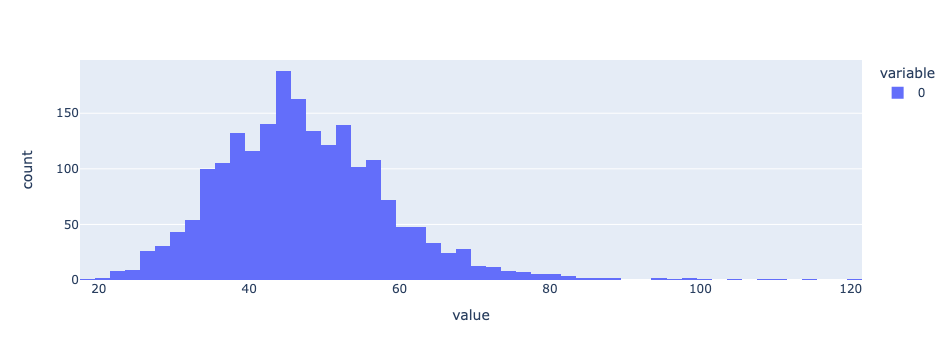

In [13]:
sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads
sae.to(device)
bsize = 3
token_idx = 512

comms_dict[sae.cfg.hook_name] = []
torch.cuda.empty_cache()
with torch.no_grad():
    natty_states = []
    intrv_states = []
    for i in tqdm(range(0,len(token_dataset),bsize)):
        # activation store can give us tokens.
        batch_tokens = token_dataset[i:i+bsize]["tokens"]
        
        
        _ = model(batch_tokens, prepend_bos=True)
        reps = comms_dict[sae.cfg.hook_name][0] #.cpu()
        comms_dict[sae.cfg.hook_name] = []
        
        #_, cache = model.run_with_cache(batch_tokens, prepend_bos=True)
        #reps = cache[sae.cfg.hook_name].cpu()
    
        # Use the SAE
        feature_acts = sae.encode(reps)
        sae_out = sae.decode(feature_acts)
        
        natty_states.append(reps.cpu()[:,token_idx])
        intrv_states.append(sae_out.cpu()[:,token_idx])

    # ignore the bos token, get the number of features that activated in each token, averaged accross batch and position
    l0 = (feature_acts[:, 1:] > 0).float().sum(-1).detach()
    print("average l0", l0.mean().item())
    px.histogram(l0.flatten().cpu().numpy()).show()

In [14]:
natty_states_all = torch.vstack(natty_states)
intrv_states_all = torch.vstack(intrv_states)

In [15]:
natty_states_all.shape

torch.Size([14390, 4096])

In [17]:
#torch.save({"natty": natty_states_all, "intrv": intrv_states_all}, "temp.p")

In [17]:
temp = torch.load("temp.p")
natty_states_all = temp["natty"].float()
intrv_states_all = temp["intrv"].float()


Natty: torch.Size([14390, 4096])
Intrv: torch.Size([14390, 4096])


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_vecs = torch.tensor(vecs[:len(natty_states)])
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:164: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  intrv_vecs = torch.tensor(vecs[len(natty_states):])
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float()
/home/grantsrb/src/pyvene_fork/divergenc

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.0179, 0.0093, 0.0082, 0.0062, 0.0058])
Vis Expl Vars: tensor(0.0179) tensor(0.0093)


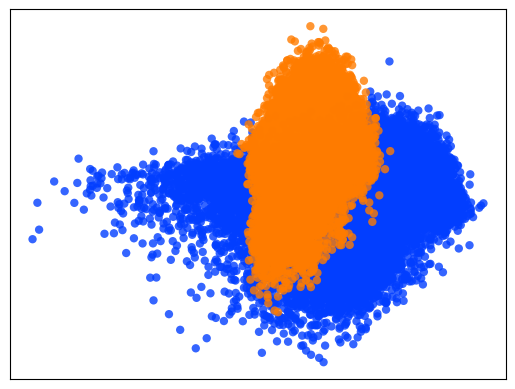

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_vecs = torch.tensor(vecs[:len(natty_states)])
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:164: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  intrv_vecs = torch.tensor(vecs[len(natty_states):])
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float()


x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.0179, 0.0093, 0.0082, 0.0062, 0.0058])
Vis Expl Vars: tensor(0.0179) tensor(0.0093)
x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.0179, 0.0093, 0.0082, 0.0062, 0.0058])
Vis Expl Vars: tensor(0.0179) tensor(0.0093)
x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.0179, 0.0093, 0.0082, 0.0062, 0.0058])
Vis Expl Vars: tensor(0.0179) tensor(0.0093)
x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.0179, 0.0093, 0.0082, 0.0062, 0.0058])
Vis Expl Vars: tensor(0.0179) tensor(0.0093)
x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.0179, 0.0093, 0.0082, 0.0062, 0.0058])
Vis Expl Vars: tensor(0.0179) tensor(0.0093)
x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.0179, 0.0093, 0.0082, 0.0062, 0.0058])
Vis Expl Vars: tensor(0.0179) tensor(0.0093)
x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.0179, 0.0093, 0.0082, 0.0062, 0.0058])
Vis Expl Vars: tensor(0.0179) tensor(0.0093)
x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.0179, 0.0093, 0.0082, 0.0062, 0.0058])
Vis Expl Vars: tensor(0.0179)

base_emd    2359.464966
emd         2972.441552
dtype: float64

In [20]:
from divergence_utils import visualize_states


np.random.seed(12345)
torch.manual_seed(12345)

n_samples = 10
d = natty_states_all.shape[-1]

natty_states = natty_states_all.reshape(-1,d).float()
intrv_states = intrv_states_all.reshape(-1,d).float()

print()
print("Natty:", natty_states.shape)
print("Intrv:", intrv_states.shape)
emd_df_dict = {
    "sample_id": [],
    "mse": [],
    "emd": [],
    "base_emd": [],
}
for samp_id in range(n_samples):
    diffs = visualize_states(
        natty_states,
        intrv_states,
        xdim=0,
        ydim=1,
        save_name="figs/sae_divergence.png",
        expl_var_threshold=0,
        emd_sample_type="permute",
        emd_sample_size=5000,
        normalize_emd=True,
        visualize=samp_id==0,
    )
    mse = diffs["mse"]
    emd = diffs["emd"]
    base_emd = diffs["base_emd"]
    emd_df_dict["sample_id"].append(samp_id)
    emd_df_dict["emd"].append(emd)
    emd_df_dict["base_emd"].append(base_emd)
    emd_df_dict["mse"].append(mse)
emd_df = pd.DataFrame(emd_df_dict)
emd_df[["base_emd","emd",]].mean()
    

In [21]:
d = dict(emd_df[["base_emd","emd",]].mean())
base_emd = d["base_emd"]
emd = d["emd"]
perc = (emd-base_emd)/base_emd
frac = emd/base_emd
print("EMD %:", perc)
print("EMD Frac:", frac)

EMD %: 0.2597947394146641
EMD Frac: 1.259794739414664


In [ ]:
emd_df

In [ ]:
emd_df["method"] = "sae"
if not os.path.exists("csvs/"):
    os.mkdir("csvs/")
emd_df.to_csv("csvs/sae_emd.csv", header=True, index=False)

examining token 3
Natty PCA


/tmp/ipykernel_701684/1568716905.py:36: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/1568716905.py:37: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/1568716905.py:38: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/3885754546.py:46: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/tmp/ipykernel_701684/3885754546.py:52: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/tmp/ipykernel_701684/3885754546.py:79: UserWarn

natty: torch.Size([2002, 4096])
intrv: torch.Size([2002, 4096])
Top Expl Vars: tensor([0.0261, 0.0178, 0.0139, 0.0114, 0.0105])
X: 0 Y: 1
Expl Vars: tensor(0.0261) tensor(0.0178)
Saved to llama3_sae_tokenidx3.png


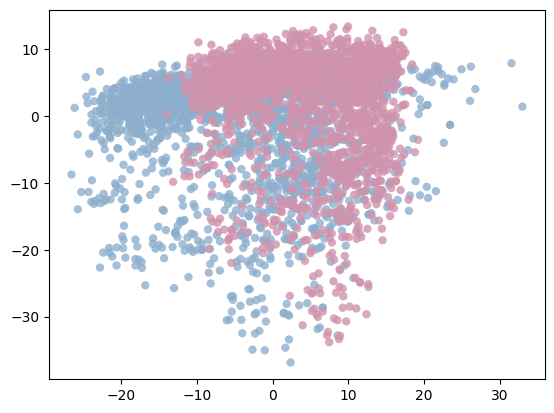

examining token 7
Natty PCA


/tmp/ipykernel_701684/1568716905.py:36: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/1568716905.py:37: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/1568716905.py:38: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/3885754546.py:46: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/tmp/ipykernel_701684/3885754546.py:52: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/tmp/ipykernel_701684/3885754546.py:79: UserWarn

natty: torch.Size([2002, 4096])
intrv: torch.Size([2002, 4096])
Top Expl Vars: tensor([0.0223, 0.0137, 0.0115, 0.0105, 0.0093])
X: 0 Y: 1
Expl Vars: tensor(0.0223) tensor(0.0137)
Saved to llama3_sae_tokenidx7.png


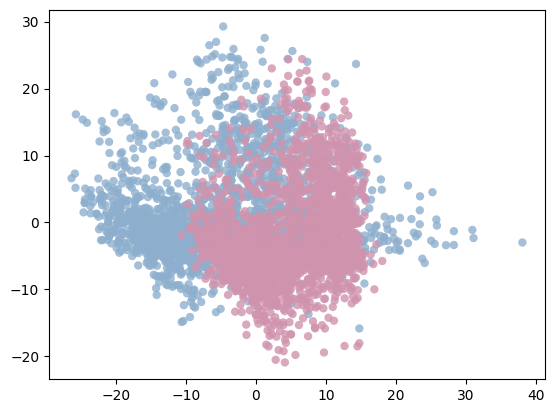

examining token 15
Natty PCA


/tmp/ipykernel_701684/1568716905.py:36: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/1568716905.py:37: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/1568716905.py:38: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/3885754546.py:46: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/tmp/ipykernel_701684/3885754546.py:52: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/tmp/ipykernel_701684/3885754546.py:79: UserWarn

natty: torch.Size([2002, 4096])
intrv: torch.Size([2002, 4096])
Top Expl Vars: tensor([0.0205, 0.0143, 0.0121, 0.0104, 0.0082])
X: 0 Y: 1
Expl Vars: tensor(0.0205) tensor(0.0143)
Saved to llama3_sae_tokenidx15.png


examining token 31
Natty PCA


/tmp/ipykernel_701684/1568716905.py:36: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/1568716905.py:37: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/1568716905.py:38: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/3885754546.py:46: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



natty: torch.Size([2002, 4096])
intrv: torch.Size([2002, 4096])
Top Expl Vars: tensor([0.0190, 0.0166, 0.0132, 0.0091, 0.0087])
X: 0 Y: 1
Expl Vars: tensor(0.0190) tensor(0.0166)


/tmp/ipykernel_701684/3885754546.py:52: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/tmp/ipykernel_701684/3885754546.py:79: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Saved to llama3_sae_tokenidx31.png


examining token 63
Natty PCA


/tmp/ipykernel_701684/1568716905.py:36: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/1568716905.py:37: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/1568716905.py:38: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/3885754546.py:46: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/tmp/ipykernel_701684/3885754546.py:52: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/tmp/ipykernel_701684/3885754546.py:79: UserWarn

natty: torch.Size([2002, 4096])
intrv: torch.Size([2002, 4096])
Top Expl Vars: tensor([0.0192, 0.0161, 0.0119, 0.0090, 0.0087])
X: 0 Y: 1
Expl Vars: tensor(0.0192) tensor(0.0161)
Saved to llama3_sae_tokenidx63.png


examining token 127
Natty PCA


/tmp/ipykernel_701684/1568716905.py:36: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/1568716905.py:37: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/1568716905.py:38: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/3885754546.py:46: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/tmp/ipykernel_701684/3885754546.py:52: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/tmp/ipykernel_701684/3885754546.py:79: UserWarn

natty: torch.Size([2002, 4096])
intrv: torch.Size([2002, 4096])
Top Expl Vars: tensor([0.0185, 0.0159, 0.0110, 0.0091, 0.0082])
X: 0 Y: 1
Expl Vars: tensor(0.0185) tensor(0.0159)
Saved to llama3_sae_tokenidx127.png


examining token 255
Natty PCA


/tmp/ipykernel_701684/1568716905.py:36: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/1568716905.py:37: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/1568716905.py:38: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/3885754546.py:46: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/tmp/ipykernel_701684/3885754546.py:52: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/tmp/ipykernel_701684/3885754546.py:79: UserWarn

natty: torch.Size([2002, 4096])
intrv: torch.Size([2002, 4096])
Top Expl Vars: tensor([0.0195, 0.0180, 0.0113, 0.0092, 0.0083])
X: 0 Y: 1
Expl Vars: tensor(0.0195) tensor(0.0180)
Saved to llama3_sae_tokenidx255.png


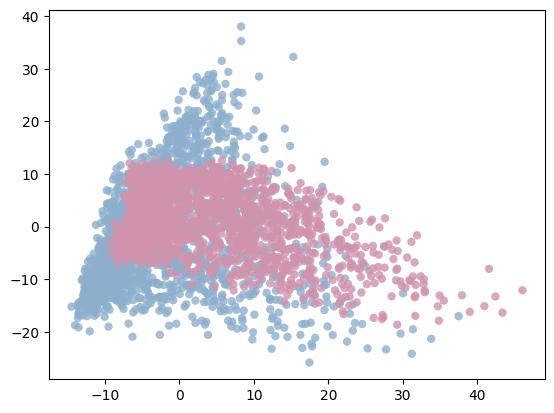

examining token 511
Natty PCA


/tmp/ipykernel_701684/1568716905.py:36: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/1568716905.py:37: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/1568716905.py:38: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_701684/3885754546.py:46: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/tmp/ipykernel_701684/3885754546.py:52: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/tmp/ipykernel_701684/3885754546.py:79: UserWarn

natty: torch.Size([2002, 4096])
intrv: torch.Size([2002, 4096])
Top Expl Vars: tensor([0.0203, 0.0186, 0.0111, 0.0093, 0.0088])
X: 0 Y: 1
Expl Vars: tensor(0.0203) tensor(0.0186)
Saved to llama3_sae_tokenidx511.png


Avg EMD: 0.7330739264394722
Base EMD: 2.0708121655034084
% EMD: 0.7330739264394722
Expl Var: 0.00241137249212639


In [30]:
import os
import numpy as np
from sklearn.decomposition import PCA, IncrementalPCA
import pandas as pd
from fca.projections import explained_variance 

kwargs = { "loss": "sinkhorn", "p": 2, "blur": 0.05, }
loss_fn = SamplesLoss(**kwargs)
def get_emd(X,Y):
    return loss_fn(X,Y).item()

avg_div = 0
avg_base = 0
avg_frac = 0
avg_ev = 0

start_idx = 4
end_idx = 1028
d = natty_states_all.shape[-1]

for token_idx in range(2,10):
    token_idx = 2**token_idx-1
    print("examining token", token_idx)
    natty_states = natty_states_all[:,token_idx].reshape(-1,d)
    intrv_states = intrv_states_all[:,token_idx].reshape(-1,d)
    visualize_states(natty_states, intrv_states, save_name=f"figs/llama3_sae_tokenidx{token_idx}.png")
    
    
n_loops = natty_states_all.shape[1] - start_idx
print("Avg EMD:", avg_div/n_loops)
print("Base EMD:", avg_base/n_loops)
print("% EMD:", avg_div/n_loops)
print("Expl Var:", avg_ev/n_loops)

Note that while the mean L0 is 64, it varies with the specific activation.

To estimate reconstruction performance, we calculate the CE loss of the model with and without the SAE being used in place of the activations. This will vary depending on the tokens.


In [60]:
from transformer_lens import utils
from functools import partial


# next we want to do a reconstruction test.
def reconstr_hook(activation, hook, sae_out):
    return sae_out


def zero_abl_hook(activation, hook):
    return torch.zeros_like(activation)


print("Orig", model(batch_tokens, return_type="loss").item())
print(
    "reconstr",
    model.run_with_hooks(
        batch_tokens,
        fwd_hooks=[
            (
                sae.cfg.hook_name,
                partial(reconstr_hook, sae_out=sae_out),
            )
        ],
        return_type="loss",
    ).item(),
)
print(
    "Zero",
    model.run_with_hooks(
        batch_tokens,
        return_type="loss",
        fwd_hooks=[(sae.cfg.hook_name, zero_abl_hook)],
    ).item(),
)

Orig 4.078335285186768
reconstr 4.297725677490234
Zero 11.452188491821289


## Specific Capability Test

Validating model performance on specific tasks when using the reconstructed activation is quite important when studying specific tasks.


In [62]:
example_prompt = "When John and Mary went to the shops, John gave the bag to"
example_answer = " Mary"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

logits, cache = model.run_with_cache(example_prompt, prepend_bos=True)
tokens = model.to_tokens(example_prompt)
sae_out = sae(cache[sae.cfg.hook_name])


def reconstr_hook(activations, hook, sae_out):
    return sae_out


def zero_abl_hook(mlp_out, hook):
    return torch.zeros_like(mlp_out)


hook_name = sae.cfg.hook_name

print("Orig", model(tokens, return_type="loss").item())
print(
    "reconstr",
    model.run_with_hooks(
        tokens,
        fwd_hooks=[
            (
                hook_name,
                partial(reconstr_hook, sae_out=sae_out),
            )
        ],
        return_type="loss",
    ).item(),
)
print(
    "Zero",
    model.run_with_hooks(
        tokens,
        return_type="loss",
        fwd_hooks=[(hook_name, zero_abl_hook)],
    ).item(),
)


with model.hooks(
    fwd_hooks=[
        (
            hook_name,
            partial(reconstr_hook, sae_out=sae_out),
        )
    ]
):
    utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' John', ' gave', ' the', ' bag', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 18.19 Prob: 69.93% Token: | Mary|

Top 0th token. Logit: 18.19 Prob: 69.93% Token: | Mary|
Top 1th token. Logit: 15.82 Prob:  6.49% Token: | them|
Top 2th token. Logit: 15.48 Prob:  4.66% Token: | the|
Top 3th token. Logit: 14.93 Prob:  2.66% Token: | his|
Top 4th token. Logit: 14.86 Prob:  2.49% Token: | John|
Top 5th token. Logit: 14.12 Prob:  1.19% Token: | her|
Top 6th token. Logit: 13.99 Prob:  1.04% Token: | their|
Top 7th token. Logit: 13.70 Prob:  0.78% Token: | a|
Top 8th token. Logit: 13.53 Prob:  0.66% Token: | him|
Top 9th token. Logit: 13.39 Prob:  0.57% Token: | Mrs|


Ranks of the answer tokens: [(' Mary', 0)]

Orig 3.979092597961426
reconstr 3.930879831314087
Zero 11.21423053741455
Tokenized prompt: ['<|endoftext|>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' John', ' gave', ' the', ' bag', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 16.75 Prob: 38.78% Token: | Mary|

Top 0th token. Logit: 16.75 Prob: 38.78% Token: | Mary|
Top 1th token. Logit: 15.73 Prob: 14.00% Token: | them|
Top 2th token. Logit: 15.11 Prob:  7.52% Token: | the|
Top 3th token. Logit: 14.82 Prob:  5.64% Token: | John|
Top 4th token. Logit: 14.76 Prob:  5.30% Token: | her|
Top 5th token. Logit: 14.11 Prob:  2.76% Token: | a|
Top 6th token. Logit: 13.86 Prob:  2.15% Token: | their|
Top 7th token. Logit: 13.75 Prob:  1.92% Token: | his|
Top 8th token. Logit: 13.74 Prob:  1.91% Token: | him|
Top 9th token. Logit: 13.15 Prob:  1.05% Token: | me|


Ranks of the answer tokens: [(' Mary', 0)]

# Generating Feature Interfaces

Feature dashboards are an important part of SAE Evaluation. They work by:

- 1. Collecting feature activations over a larger number of examples.
- 2. Aggregating feature specific statistics (such as max activating examples).
- 3. Representing that information in a standardized way

For our feature visualizations, we will use a separate library called SAEDashboard.


In [63]:
# Make sure to install sae-dashboard if not running in colab
# pip install sae-dashboard
# Note: this cell may not work until sae-dashboard is updated to work with the latest version of sae-lens

test_feature_idx_gpt = list(range(10)) + [14057]

from sae_dashboard.sae_vis_data import SaeVisConfig
from sae_dashboard.sae_vis_runner import SaeVisRunner


feature_vis_config_gpt = SaeVisConfig(
    hook_point=hook_name,
    features=test_feature_idx_gpt,
    minibatch_size_features=64,
    minibatch_size_tokens=256,
    verbose=True,
    device=device,
)

visualization_data_gpt = SaeVisRunner(
    feature_vis_config_gpt
).run(
    encoder=sae,  # type: ignore
    model=model,
    tokens=token_dataset[:10000]["tokens"],  # type: ignore
)
# SaeVisData.create(
#     encoder=sae,
#     model=model, # type: ignore
#     tokens=token_dataset[:10000]["tokens"],  # type: ignore
#     cfg=feature_vis_config_gpt,
# )

Forward passes to cache data for vis:   0%|          | 0/40 [00:00<?, ?it/s]

Extracting vis data from cached data:   0%|          | 0/11 [00:00<?, ?it/s]

┏━━━━━━┳━━━━━━┳━━━━━━━┓
┃ Task ┃ Time ┃ Pct % ┃
┡━━━━━━╇━━━━━━╇━━━━━━━┩
└──────┴──────┴───────┘

In [64]:
from sae_dashboard.data_writing_fns import save_feature_centric_vis

filename = f"demo_feature_dashboards.html"
save_feature_centric_vis(sae_vis_data=visualization_data_gpt, filename=filename)

Saving feature-centric vis:   0%|          | 0/11 [00:00<?, ?it/s]

Now, since generating feature dashboards can be done once per sparse autoencoder, for pre-trained SAEs in the public domain, everyone can use the same dashboards. Neuronpedia hosts dashboards which we can load via the integration.


In [66]:
from sae_lens.analysis.neuronpedia_integration import get_neuronpedia_quick_list

# this function should open
neuronpedia_quick_list = get_neuronpedia_quick_list(sae, test_feature_idx_gpt)

print(neuronpedia_quick_list)

https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%220%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%221%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%222%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%223%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%224%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%225%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%226%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%227%22%7D%2C%20%7B%22modelId%22%3A%